# Hard Problem

Implementation of a non-convex campaign-level budget optimization using a logistic S-curve response model, followed by impression-level allocation using pCONV-per-cost ranking.


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution
import io
from google.colab import files

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['criteo_processed_pconv.csv']))

Saving criteo_processed_pconv.csv to criteo_processed_pconv.csv


# Basic Preprocessing

In [ ]:
# Keep only impressions with positive cost
df = df[df["cost"] > 0].reset_index(drop=True)

# Sanity check columns
required_cols = ["campaign", "cost", "conversion", "pCONV", "pCONV_per_cost"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in df: {missing}")

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist()[:20])

Data shape: (50000, 19)
Columns: ['Unnamed: 0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'campaign', 'time_since_last_click', 'click_pos', 'click_nb', 'cost', 'click', 'conversion', 'pCONV', 'pCONV_per_cost']


## Problem Description

$$
f_k(S_k) = \frac{L_k}{1 + \exp(-a_k (S_k - b_k))}
$$

Where:
- L_k = saturation level  
- a_k = steepness of the curve  
- b_k = spend where growth is fastest (inflection point)
- S_k = spend on campaign k
- f_k(S_k) = expected conversions on spending S_k

These encode diminishing returns for each campaign.

Constraints:

- sum(S_k) ≤ B
- min_cap ≤ S_k ≤ max_cap
- (f_k(S_k) / S_k) ≥ min_ROI

In [ ]:
# Aggregate per-campaign stats & define S-curve parameters

camp_stats = (
    df.groupby("campaign")
      .agg(
          hist_spend=("cost", "sum"),
          hist_pred_conv=("pCONV", "sum"),
          hist_impressions=("campaign", "size"),
          hist_actual_conv=("conversion", "sum")
      )
      .reset_index()
)

campaigns = camp_stats["campaign"].to_numpy()
hist_spend = camp_stats["hist_spend"].to_numpy()
hist_pred_conv = camp_stats["hist_pred_conv"].to_numpy()
hist_actual_conv = camp_stats["hist_actual_conv"].to_numpy()
K = len(campaigns)

print(f"Number of campaigns: {K}")

Number of campaigns: 637


In [ ]:
eps = 1e-8

L_k = np.maximum(2.0 * hist_pred_conv, eps)  # saturation - at most 2x current predicted conversions
b_k = np.maximum(hist_spend, eps)
a_k = 4.0 / b_k

# Historical predicted ROI and min ROI per campaign
roi_hist = np.where(hist_spend > 0, hist_pred_conv / hist_spend, 0.0)
roi_floor_factor = 0.8   # 80% of historical predicted ROI
R_min_k = roi_floor_factor * roi_hist

camp_stats["L_k"] = L_k
camp_stats["a_k"] = a_k
camp_stats["b_k"] = b_k
camp_stats["ROI_hist"] = roi_hist
camp_stats["ROI_min"] = R_min_k

camp_stats.head()

,campaign,hist_spend,hist_pred_conv,hist_impressions,hist_actual_conv,L_k,a_k,b_k,ROI_hist,ROI_min
0,0,0.000834,3.197801e-07,5,0,6.395603e-07,4794.651481,0.000834,0.000383,0.000307
1,1,0.001783,3.000002e+00,33,3,6.000003e+00,2243.887402,0.001783,1682.916475,1346.333180
2,2,0.010364,6.000002e+00,48,6,1.200000e+01,385.963532,0.010364,578.945528,463.156422
3,3,0.007168,1.000000e+01,75,10,2.000001e+01,558.006779,0.007168,1395.017401,1116.013921
4,4,0.025973,4.000003e+00,78,4,8.000006e+00,154.007789,0.025973,154.007906,123.206325


In [ ]:
B = df["cost"].sum() * 0.1  # 10% of historical total spend
print(f"Total budget B = {B:.2f}")

min_cap = np.zeros_like(hist_spend)
max_cap = np.minimum(3.0 * hist_spend, B)
min_cap = np.maximum(min_cap, 0.0)
max_cap = np.maximum(max_cap, 0.0)

Total budget B = 1.30


#Logistic Response and Penaly Functions

Penalties apply when:
- total spend exceeds budget  
- spend violates min/max caps  
- ROI falls below required threshold

In [ ]:
# returns expected conversions per campaign
def logistic_response(S, L, a, b):
    S = np.maximum(S, 0.0)
    return L / (1.0 + np.exp(-a * (S - b)))


def penalized_objective(S_flat):
    S = np.array(S_flat, dtype=float)
    S = np.maximum(S, 0.0)

    conv = logistic_response(S, L_k, a_k, b_k)
    total_conv = conv.sum()

    penalty = 0.0

    # budget constraint: sum(spend) <= B
    total_spend = S.sum()
    if total_spend > B:
        penalty += 1e5 * (total_spend - B) ** 2

    # per-campaign min/max caps
    for i in range(K):
        if S[i] < min_cap[i]:
            penalty += 1e5 * (min_cap[i] - S[i]) ** 2
        if S[i] > max_cap[i]:
            penalty += 1e5 * (S[i] - max_cap[i]) ** 2

    # ROI constraints per campaign: expected conversions/spend >= min ROI
    for i in range(K):
        if S[i] > 1e-6:
            roi_i = conv[i] / S[i]
            shortfall = R_min_k[i] - roi_i
            if shortfall > 0:
                penalty += 1e5 * (shortfall ** 2)

    return -total_conv + penalty

In [ ]:
bounds = [(float(min_cap[i]), float(max_cap[i])) for i in range(K)]

print("Bounds example for first 5 campaigns:")
for i in range(min(5, K)):
    print(f"campaign {campaigns[i]}: [{bounds[i][0]:.2f}, {bounds[i][1]:.2f}]")

Bounds example for first 5 campaigns:
campaign 0: [0.00, 0.00]
campaign 1: [0.00, 0.01]
campaign 2: [0.00, 0.03]
campaign 3: [0.00, 0.02]
campaign 4: [0.00, 0.08]


#Solving the problem with Differential Evolution

Objective:

Minimize   −∑​fk​(Sk​) + penalties

In [ ]:
result = differential_evolution(
    penalized_objective,
    bounds,
    maxiter=20,
    popsize=15,
    tol=1e-6,
    polish=True,
    disp=True
)

S_opt = np.maximum(result.x, 0.0)
conv_opt = logistic_response(S_opt, L_k, a_k, b_k)
total_conv_opt = conv_opt.sum()
roi_opt = np.where(S_opt > 1e-6, conv_opt / S_opt, 0.0)

print("\nNon-convex optimization results (campaign-level)")
print("Status:", result.message)
print(f"Total expected conversions (logistic model): {total_conv_opt:.6f}")
print(f"Total spend used: {S_opt.sum():.2f} (budget B = {B:.2f})")

differential_evolution step 1: f(x)= 115631865163.24333
differential_evolution step 2: f(x)= 82871783757.47191
differential_evolution step 3: f(x)= 66179121187.37044
differential_evolution step 4: f(x)= 56768651717.65732
differential_evolution step 5: f(x)= 56768651717.65732
differential_evolution step 6: f(x)= 56768651717.65732
differential_evolution step 7: f(x)= 51977609268.62938
differential_evolution step 8: f(x)= 42656998313.90061
differential_evolution step 9: f(x)= 39383099556.683044
differential_evolution step 10: f(x)= 39383099556.683044
differential_evolution step 11: f(x)= 39383099556.683044
differential_evolution step 12: f(x)= 28804459629.924877
differential_evolution step 13: f(x)= 28804459629.924877
differential_evolution step 14: f(x)= 24333948324.305016
differential_evolution step 15: f(x)= 24333948324.305016
differential_evolution step 16: f(x)= 14571576996.309975


In [ ]:
solution_campaign = pd.DataFrame({
    "campaign": campaigns,
    "S_opt": S_opt,
    "expected_conv_logistic": conv_opt,
    "ROI_opt_logistic": roi_opt,
    "ROI_min": R_min_k,
    "hist_spend": hist_spend,
    "hist_pred_conv": hist_pred_conv,
    "hist_actual_conv": hist_actual_conv,
    "ROI_hist": roi_hist,
    "min_cap": min_cap,
    "max_cap": max_cap,
}).sort_values("S_opt", ascending=False)

solution_campaign.head(15)

,campaign,S_opt,expected_conv_logistic,ROI_opt_logistic,ROI_min,hist_spend,hist_pred_conv,hist_actual_conv,ROI_hist,min_cap,max_cap
202,202,1.208524,479.950136,397.137513,268.342077,0.834756,280.000133,280,335.427597,0.0,1.301528
307,307,0.550003,123.715019,224.935303,164.976574,0.315196,65.000027,65,206.220718,0.0,0.945589
93,93,0.410477,22.365356,54.486308,37.748515,0.339087,16.000035,16,47.185644,0.0,1.017261
310,310,0.354177,103.693021,292.771930,234.564300,0.354700,104.000054,104,293.205375,0.0,1.064101
540,540,0.325687,73.900959,226.907893,153.487971,0.250183,48.000017,48,191.859963,0.0,0.750548
549,549,0.285124,53.802851,188.699600,181.983432,0.118692,27.000025,27,227.479290,0.0,0.356077
596,596,0.280099,28.052941,100.153807,67.621374,0.212951,18.000017,18,84.526717,0.0,0.638852
472,472,0.280096,21.958014,78.394737,80.572914,0.109218,11.000028,11,100.716142,0.0,0.327654
133,133,0.279275,37.262670,133.426435,90.832614,0.220185,25.000022,25,113.540767,0.0,0.660556
619,619,0.273385,43.605047,159.500312,140.087509,0.125636,22.000021,22,175.109386,0.0,0.376908


Map optimal campaign spend to impression-level allocation

In [ ]:
# allocation x_hard_i in [0, 1] per impression
# within each campaign, allocate greedily by pCONV_per_cost descending
df = df.copy()
df["x_hard"] = 0.0
df["spend_hard"] = 0.0

cost_arr = df["cost"].to_numpy()
density_arr = df["pCONV_per_cost"].to_numpy()
campaign_arr = df["campaign"].to_numpy()
pconv_arr = df["pCONV"].to_numpy()
conv_arr = df["conversion"].to_numpy()

campaign_to_Sopt = dict(zip(campaigns, S_opt))

for camp in campaigns:
    target_spend = campaign_to_Sopt[camp]
    if target_spend <= 0:
        continue

    idx = np.where(campaign_arr == camp)[0]
    if len(idx) == 0:
        continue

    sub_density = density_arr[idx]
    order = np.argsort(-sub_density)
    idx_sorted = idx[order]

    remaining = target_spend

    for i in idx_sorted:
        if remaining <= 0:
            break
        c = cost_arr[i]
        if c <= 0:
            continue

        take = min(1.0, remaining / c)
        df.at[i, "x_hard"] = take
        df.at[i, "spend_hard"] = take * c
        remaining -= take * c

# Results

In [ ]:
total_spend_hard = df["spend_hard"].sum()
expected_conv_hard = (df["pCONV"] * df["x_hard"]).sum()
actual_conv_hard = (df["conversion"] * df["x_hard"]).sum()

print("\nImpression-level evaluation:")
print(f"Total spend (x_hard): {total_spend_hard:.2f} (budget B = {B:.2f})")
print(f"Expected conversions (using pCONV): {expected_conv_hard:.6f}")
print(f"Weighted actual conversions from data: {actual_conv_hard:.6f}")

hard_campaign_view = (
    df.groupby("campaign")
      .agg(
          spend_hard=("spend_hard", "sum"),
          impressions_selected=("x_hard", lambda x: (x > 0).sum()),
          expected_conv_hard=("pCONV", lambda p: (p * df.loc[p.index, "x_hard"]).sum()),
          actual_conv_hard=("conversion", lambda c: (c * df.loc[c.index, "x_hard"]).sum()),
      )
      .reset_index()
      .merge(solution_campaign[["campaign", "S_opt"]], on="campaign", how="left")
      .sort_values("spend_hard", ascending=False)
)

hard_campaign_view.head(15)


Impression-level evaluation:
Total spend (x_hard): 11.55 (budget B = 1.30)
Expected conversions (using pCONV): 2642.937303
Weighted actual conversions from data: 2642.935180


,campaign,spend_hard,impressions_selected,expected_conv_hard,actual_conv_hard,S_opt
202,202,0.834756,3177,280.000133,280.0,1.208524
310,310,0.354177,1323,104.000054,104.0,0.354177
93,93,0.339087,734,16.000035,16.0,0.410477
307,307,0.315196,548,65.000027,65.0,0.550003
603,603,0.267470,4456,169.000202,169.0,0.267470
540,540,0.250183,403,48.000017,48.0,0.325687
630,630,0.243898,407,124.000010,124.0,0.243898
133,133,0.220185,522,25.000022,25.0,0.279275
596,596,0.212951,368,18.000017,18.0,0.280099
354,354,0.191516,904,14.000039,14.0,0.238426


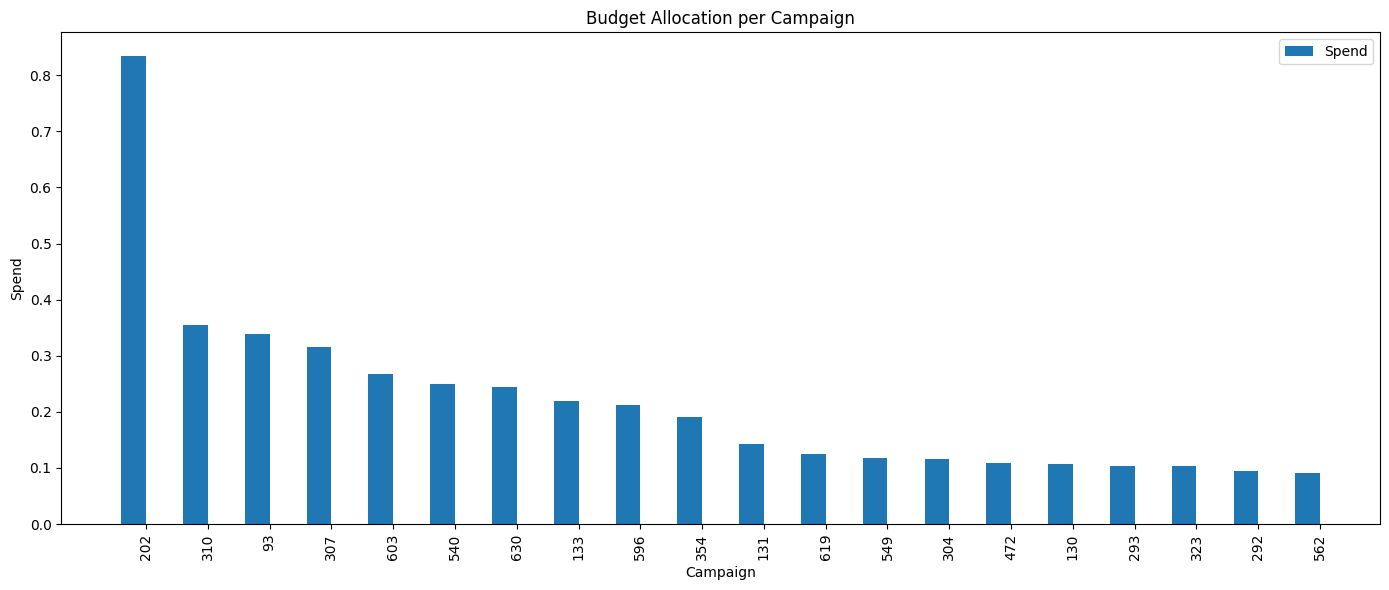

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plot_df = hard_campaign_view.merge(
    solution_campaign[["campaign", "S_opt"]],
    on="campaign",
    how="left",
    suffixes=("", "_target")
).sort_values("spend_hard", ascending=False)

TOP_N = 20
plot_df_top = plot_df.head(TOP_N)

campaign_labels = plot_df_top["campaign"].astype(str).tolist()
spend_actual = plot_df_top["spend_hard"].to_numpy()
spend_target = plot_df_top["S_opt"].to_numpy()

x_pos = np.arange(len(campaign_labels))
width = 0.4

plt.figure(figsize=(14, 6))
plt.bar(x_pos - width/2, spend_actual, width=width, label="Spend")

plt.xticks(x_pos, campaign_labels, rotation=90)
plt.xlabel("Campaign")
plt.ylabel("Spend")
plt.title("Budget Allocation per Campaign")
plt.legend()
plt.tight_layout()
plt.show()

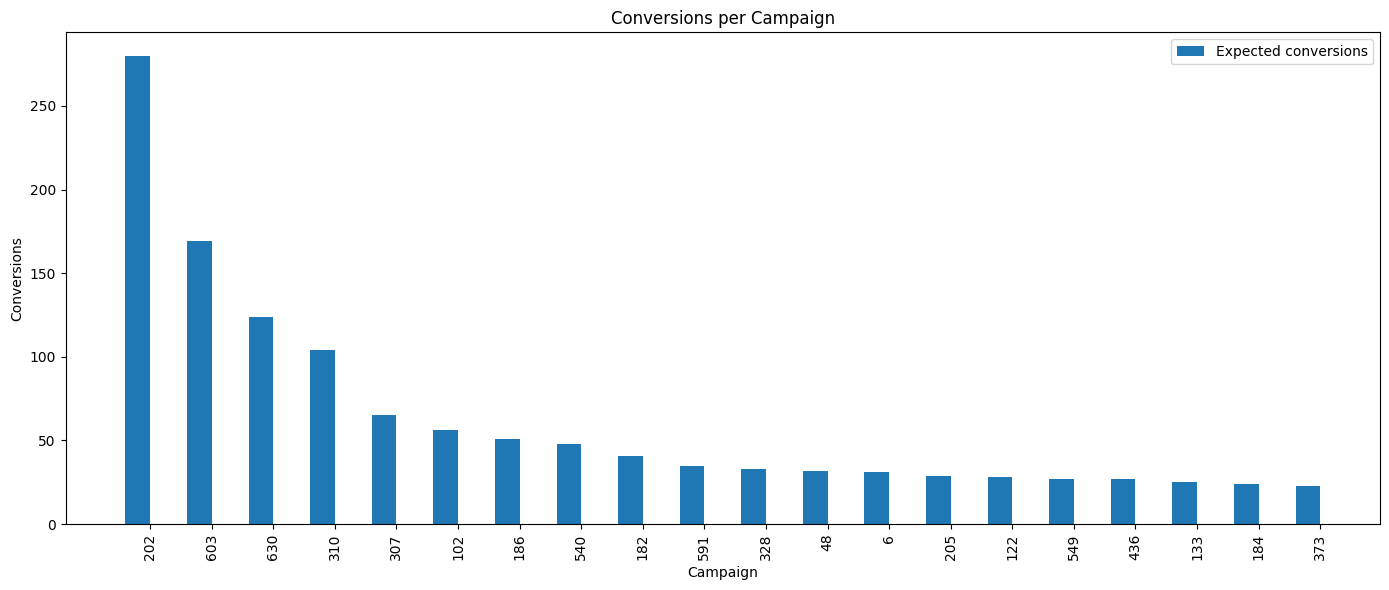

In [ ]:
conv_plot_df = hard_campaign_view.sort_values(
    "expected_conv_hard", ascending=False
)

TOP_N = 20
conv_plot_df_top = conv_plot_df.head(TOP_N)

campaign_labels = conv_plot_df_top["campaign"].astype(str).tolist()
exp_conv = conv_plot_df_top["expected_conv_hard"].to_numpy()
act_conv = conv_plot_df_top["actual_conv_hard"].to_numpy()

x_pos = np.arange(len(campaign_labels))
width = 0.4

plt.figure(figsize=(14, 6))
plt.bar(x_pos - width/2, exp_conv, width=width, label="Expected conversions")

plt.xticks(x_pos, campaign_labels, rotation=90)
plt.xlabel("Campaign")
plt.ylabel("Conversions")
plt.title("Conversions per Campaign")
plt.legend()
plt.tight_layout()
plt.show()
